1. Data Understanding & Loading

--- Initial DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 no

/tmp/ipython-input-3635069581.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0})
/tmp/ipython-input-3635069581.py:75: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})


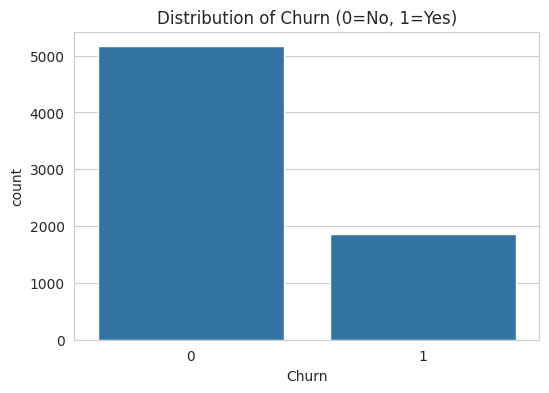

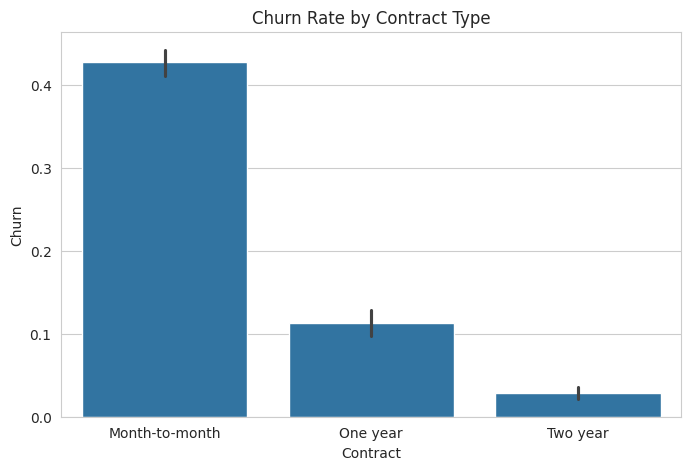

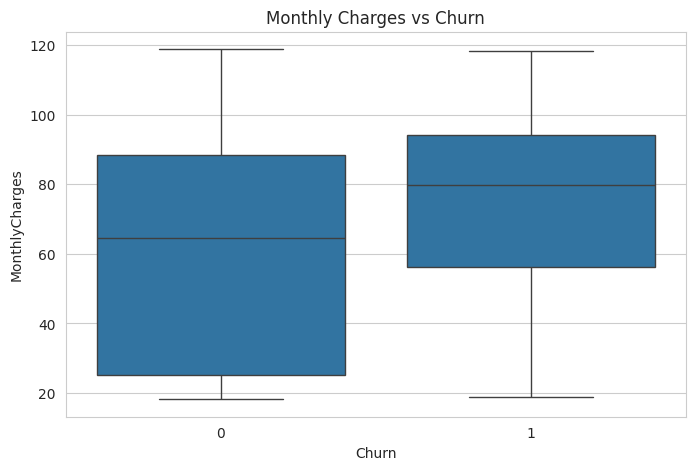

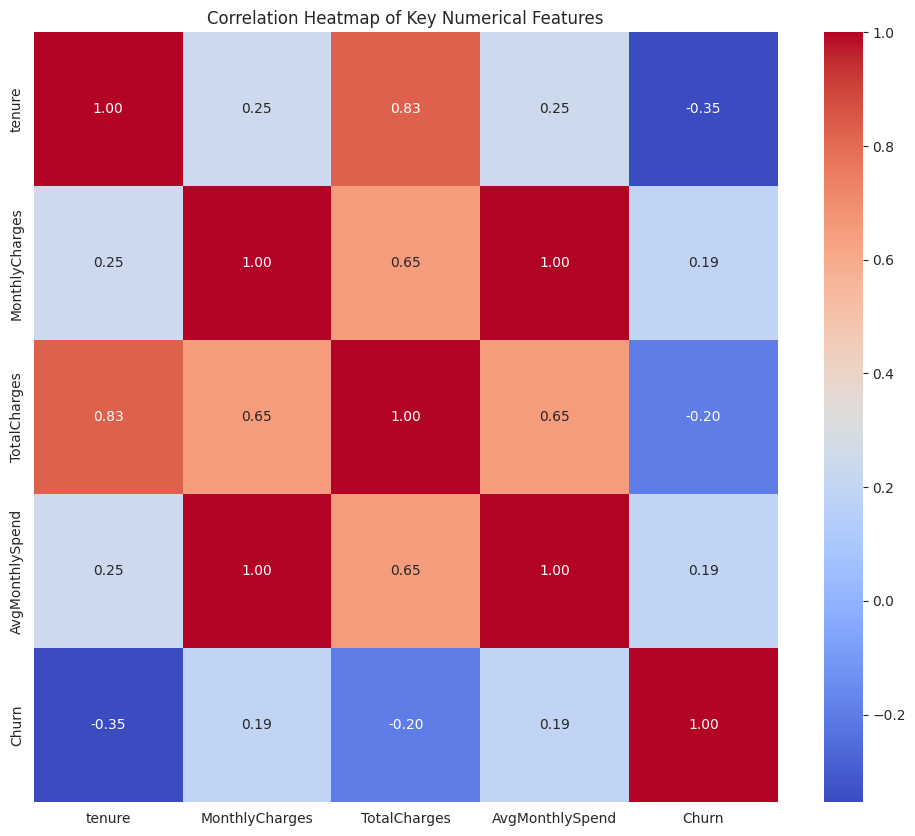

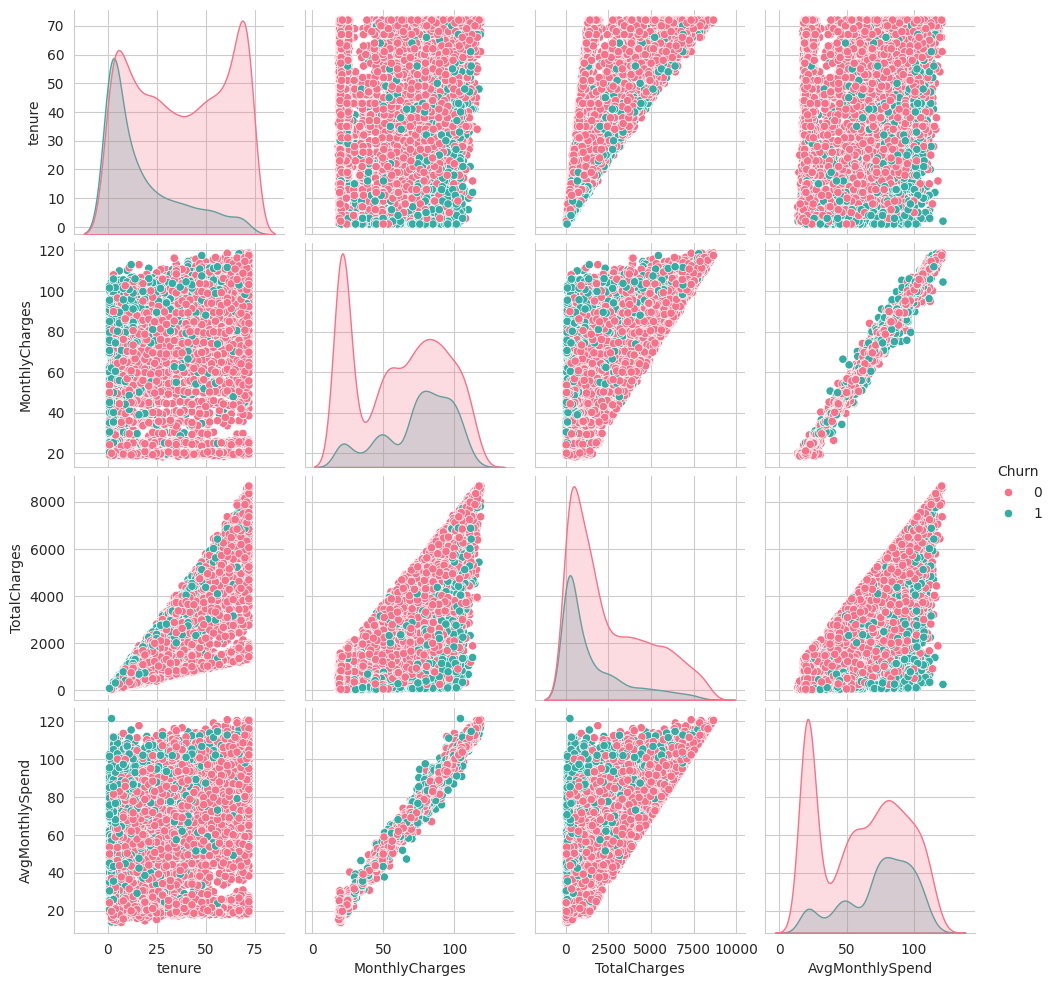



Cleaned data saved to 'cleaned_churn_data.csv'


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set plotting style for better visualization
sns.set_style("whitegrid")

# 1. Data Understanding & Loading
print("1. Data Understanding & Loading")
# NOTE: You must have the 'Telco-Customer-Churn.csv' file in your working directory.
try:
    df = pd.read_csv('customer churn data.csv')
    print("\n--- Initial DataFrame Info ---")
    df.info()
    print("\n--- Initial DataFrame Description ---")
    print(df.describe(include='all'))
except FileNotFoundError:
    print("Error: The 'Telco-Customer-Churn.csv' file was not found.")
    print("Please download it from Kaggle and place it in the same directory as this script.")
    # Exit the script gracefully if the file is not found
    exit()

# 2. Data Cleaning
print("\n\n2. Data Cleaning")
# Convert 'TotalCharges' to numeric and handle missing values
print("Fixing 'TotalCharges' column...")
# Replace spaces with NaN and convert to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows where 'TotalCharges' is missing (which were originally spaces)
print(f"Number of rows with missing TotalCharges before drop: {df['TotalCharges'].isnull().sum()}")
df.dropna(inplace=True)
print(f"Number of rows with missing TotalCharges after drop: {df['TotalCharges'].isnull().sum()}")

# Remove 'customerID' as it's not a useful feature for modeling
df.drop('customerID', axis=1, inplace=True)

print("\n--- DataFrame Info after Cleaning ---")
df.info()

# 3. Feature Engineering
print("\n\n3. Feature Engineering")

# Create a 'TenureGroup' feature by binning the continuous 'tenure' column
print("Creating 'TenureGroup' feature...")
def tenure_group(tenure):
    if 0 <= tenure <= 12:
        return '0-12 Months'
    elif 13 <= tenure <= 24:
        return '13-24 Months'
    elif 25 <= tenure <= 36:
        return '25-36 Months'
    elif 37 <= tenure <= 48:
        return '37-48 Months'
    elif 49 <= tenure <= 60:
        return '49-60 Months'
    else:
        return '61+ Months'

df['TenureGroup'] = df['tenure'].apply(tenure_group)

# Create 'AvgMonthlySpend' feature
print("Creating 'AvgMonthlySpend' feature...")
df['AvgMonthlySpend'] = df['TotalCharges'] / df['tenure']

# Convert binary categorical features to 1/0
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
               'StreamingMovies', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].replace({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0})

# Label encode 'gender'
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})

# One-hot encode other categorical columns
categorical_cols = ['Contract', 'InternetService', 'PaymentMethod', 'TenureGroup']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\n--- DataFrame Info after Feature Engineering and Encoding ---")
df_encoded.info()

# 4. EDA & Visualization
print("\n\n4. EDA & Visualization")

# Countplot for Churn
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn (0=No, 1=Yes)')
plt.show()

# Barplot: Contract vs Churn
plt.figure(figsize=(8, 5))
sns.barplot(x='Contract', y='Churn', data=df)
plt.title('Churn Rate by Contract Type')
plt.show()

# Boxplot: MonthlyCharges by Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

# Heatmap of correlations
plt.figure(figsize=(12, 10))
corr_matrix = df_encoded[['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'Churn']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Key Numerical Features')
plt.show()

# Create pairplot of key numerical features
sns.pairplot(df_encoded[['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'Churn']], hue='Churn', palette='husl')
plt.show()

# 5. Deliverables: Saving the cleaned data
df_encoded.to_csv('cleaned_churn_data.csv', index=False)
print("\n\nCleaned data saved to 'cleaned_churn_data.csv'")